# BPSK postprocessing

This notebook shows postprocessing of a 9k6 BPSK signal, with the goal of reverse engineering the coding and protocols.

The signals used here were tranmitted by an unknown satellite at 2018-01-28 12:15 UTC around 435.525MHz. The recording of the signals was made by JA0CAW.

The signal transmits in packets and there is a lot of fading, so a loop based approach to demodulation would probably give many bit errors. Here we try to process packets completely.

I have extracted two of the strongest packets from JA0CAW's recording. They are stored as binary files of 32bit floats at 48ksps (real signal) with an IF of 12kHz (1/4 the sample rate).

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal

We open the first packet and plot the samples. The fading in the signal is apparent.

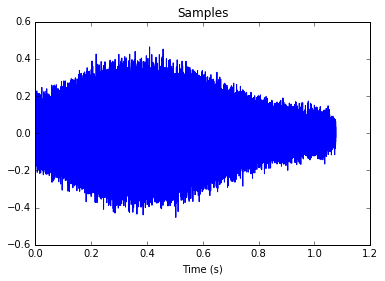

In [2]:
samp_rate = 48000
x = np.fromfile('bpsk/packet1.f32', dtype='float32')
t = np.arange(x.size)/samp_rate
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.title('Samples');

Next we use the Hilbert transform and multiply by a complex exponential to bring the signal down to IQ baseband.

In [3]:
z = scipy.signal.hilbert(x)*np.exp(-1j*2*np.pi*np.arange(x.size)/4)

To recover the supressed carrier, we compute the square of the signal to remove the BPSK modulation. This gives us a carrier at twice the supressed carrier's frequency.

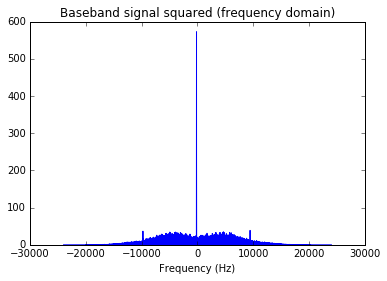

In [4]:
ff = np.fft.fft(z**2)
plt.plot(np.fft.fftshift(np.fft.fftfreq(z.size, 1/48e3)), np.abs(np.fft.fftshift(ff)))
plt.title('Baseband signal squared (frequency domain)')
plt.xlabel('Frequency (Hz)');

To obtain the phase of the suppresed carrier, we low-pass filter the signal squared in the frequency domain, then get its phase and divide by 2.

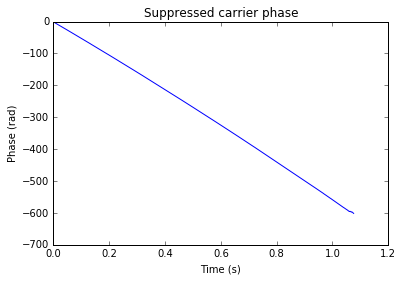

In [5]:
bins = 500
lowpass_f = np.concatenate((np.ones(bins//2), np.zeros(ff.size-bins), np.ones(bins//2)))
carrier_sq = np.fft.ifft(ff * lowpass_f)
phase = np.unwrap(np.angle(carrier_sq))/2

plt.plot(t, phase)
plt.xlabel('Time (s)')
plt.ylabel('Phase (rad)')
plt.title('Suppressed carrier phase');

The phase of the suppressed carrier varies almost linearly, since the frequency of the signal is not exactly 0Hz. It is interesting to remove the linear trend. The remaining changes in the phase are mostly caused by the satellite's accelaration (from the point of view of the receiver).

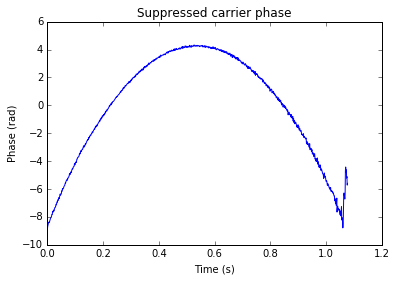

In [6]:
plt.plot(t, scipy.signal.detrend(phase))
plt.title('Suppresed carrier phase (linear detrend)')
plt.xlabel('Time (s)')
plt.ylabel('Phase (rad)')
plt.title('Suppressed carrier phase');

We use the phase of the suppressed carrier to bring the BPSK signal to the I component.

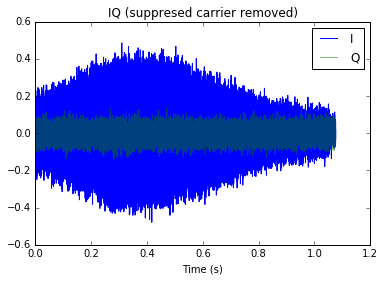

In [7]:
zz = z*np.exp(-1j * phase)
plt.plot(t, zz.real)
plt.plot(t, zz.imag, alpha=0.5)
plt.title('IQ (suppresed carrier removed)')
plt.legend(['I','Q'])
plt.xlabel('Time (s)');

Now we build an RRC filter to perform clock recovery and bit slicing. As we can see, the filter does not satisfy the Nyquist ISI criterion, but the convolution of the transmit RRC filter and the receive RRC filter is an RC filter which does satisfy the ISI criterion.

/usr/lib64/python3.5/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


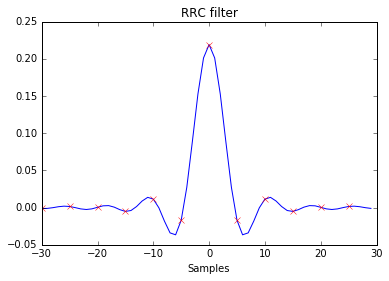

In [8]:
n = np.arange(-30,30)
beta = alpha = 0.35
T = 5
h = 1/T*(np.sin(np.pi*n/T*(1-beta))+4*beta*n/T*np.cos(np.pi*n/T*(1+beta)))/(np.pi*n/T*(1-(4*beta*n/T)**2))
h[30] = 1/T*(1+beta*(4/np.pi-1))
plt.plot(n,h)
plt.plot(n[::5],h[::5], 'x', color='red')
plt.xlabel('Samples')
plt.title('RRC filter');

For clock recovery we use a very simple approach. We use a constant clock frequency of 5 samples per clock cycle and we guess the phase of the clock by trial and error (if we don't do any interpolation or polyphase filtering of the signal, there are only 5 possible phases).

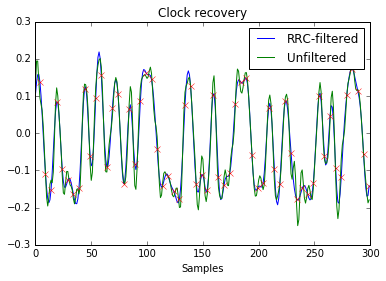

In [9]:
bpsk = zz.real
bpsk_f = scipy.signal.convolve(bpsk, h)
start = 0
end = 300
shift = 4
plt.plot(bpsk_f[start+30:end+30])
plt.plot(bpsk[start:end])
plt.plot(np.arange(shift,shift+end-start,5), bpsk_f[np.arange(shift+start+30,shift+end+30,5)], 'x', color='red')
plt.title('Clock recovery')
plt.xlabel('Samples')
plt.legend(['RRC-filtered', 'Unfiltered']);

Now we examine the quality of the clock recovery by plotting the soft bits. We see that we shouldn't expect any bit errors, except at the end of the packet, where the signal fades into the noise.

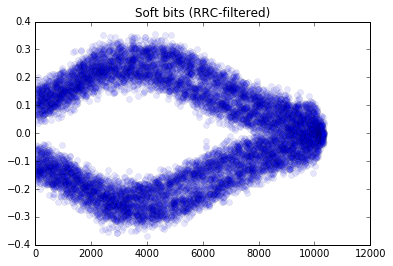

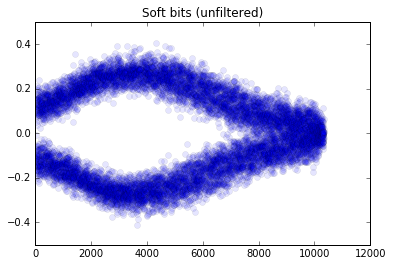

In [10]:
bits = bpsk_f[shift+30::5]
plt.plot(bits,'o', alpha=0.1)
plt.title('Soft bits (RRC-filtered)')
plt.figure()
plt.title('Soft bits (unfiltered)')
plt.plot(bpsk[shift::5], 'o', alpha=0.1);

Now we do the same procedure with the second packet.

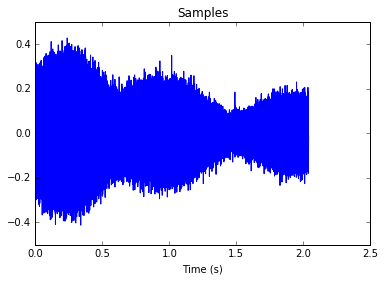

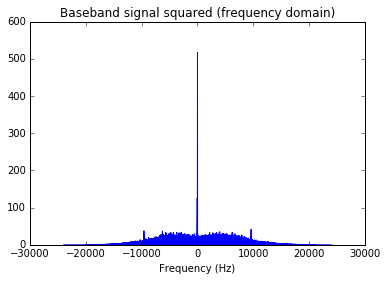

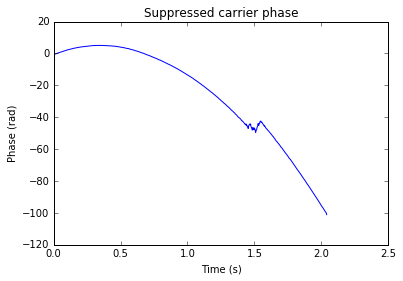

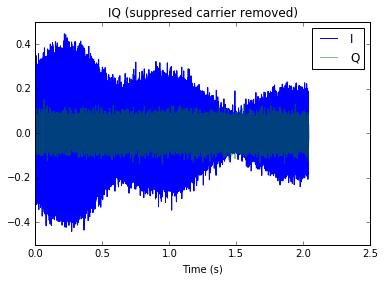

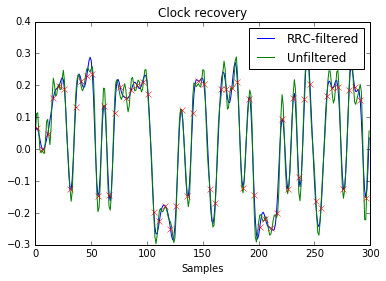

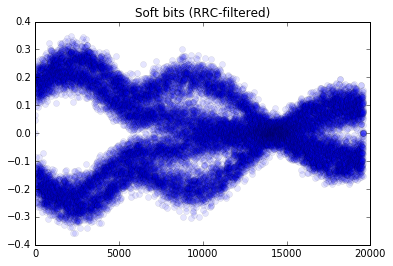

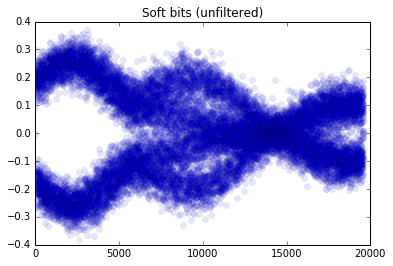

In [11]:
x = np.fromfile('bpsk/packet2.f32', dtype='float32')
t = np.arange(x.size)/samp_rate
plt.plot(t, x)
plt.xlabel('Time (s)')
plt.title('Samples');
z = scipy.signal.hilbert(x)*np.exp(-1j*2*np.pi*(np.arange(x.size))*(1-0.023)/4)
ff = np.fft.fft(z**2)
plt.figure()
plt.plot(np.fft.fftshift(np.fft.fftfreq(z.size, 1/48e3)), np.abs(np.fft.fftshift(ff)))
plt.title('Baseband signal squared (frequency domain)')
plt.xlabel('Frequency (Hz)');
bins = 500
lowpass_f = np.concatenate((np.ones(bins//2), np.zeros(ff.size-bins), np.ones(bins//2)))
carrier_sq = np.fft.ifft(ff * lowpass_f)
phase = np.unwrap(np.angle(carrier_sq))/2
plt.figure()
plt.plot(t, phase)
plt.xlabel('Time (s)')
plt.ylabel('Phase (rad)')
plt.title('Suppressed carrier phase');
ff = np.fft.fft(z**2)
zz = z*np.exp(-1j * phase)
plt.figure()
plt.plot(t, zz.real)
plt.plot(t, zz.imag, alpha=0.5)
plt.title('IQ (suppresed carrier removed)')
plt.legend(['I','Q'])
plt.xlabel('Time (s)');
bpsk = zz.real
bpsk_f = scipy.signal.convolve(bpsk, h)
start = 0
end = 300
shift = 1
plt.figure()
plt.plot(bpsk_f[start+30:end+30])
plt.plot(bpsk[start:end])
plt.plot(np.arange(shift,shift+end-start,5), bpsk_f[np.arange(shift+start+30,shift+end+30,5)], 'x', color='red')
plt.title('Clock recovery')
plt.xlabel('Samples')
plt.legend(['RRC-filtered', 'Unfiltered']);
bits2 = bpsk_f[shift+30::5]
plt.figure()
plt.plot(bits2,'o', alpha=0.1)
plt.title('Soft bits (RRC-filtered)')
plt.figure()
plt.title('Soft bits (unfiltered)')
plt.plot(bpsk[shift::5], 'o', alpha=0.1);

Now we compute the self-correlations and cross-correlations of the two packets. We observe several correlation peaks that show some structure in the packets.

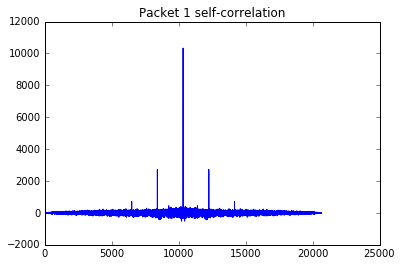

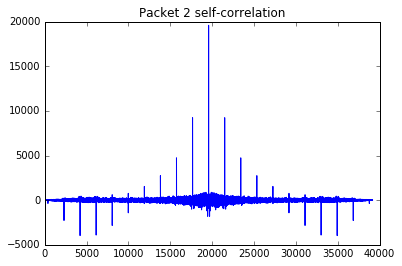

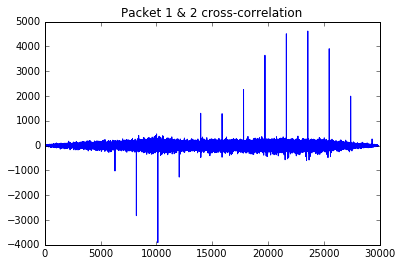

In [12]:
corr1 = np.correlate(np.sign(bits),np.sign(bits), mode='full')
plt.plot(corr1)
plt.title('Packet 1 self-correlation')
plt.figure()
corr2 = np.correlate(np.sign(bits2),np.sign(bits2), mode='full')
plt.plot(corr2)
plt.title('Packet 2 self-correlation')
plt.figure()
plt.title('Packet 1 & 2 cross-correlation')
crosscorr = np.correlate(np.sign(bits),np.sign(bits2),mode='full')
plt.plot(crosscorr);

The self-correlation peaks are spaced 1920 bits apart, meaning that there is some structure inside the packet that repeats every 240 bits.

In [13]:
np.diff(np.flatnonzero(corr1 > 500))

array([1920, 1920, 1920, 1920])

In [14]:
np.diff(np.flatnonzero(corr2 > 1000))

array([1920, 1920, 1920, 1920, 1920, 1920, 1920, 1920])

To investigate the repeating sections, we compute the XOR (product) of each packet with the same packet delayed 1920 bits. We get a section of 1's where the bits coincide.

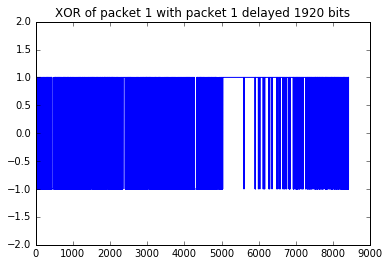

In [15]:
plt.plot(np.sign(bits[:-1920])*np.sign(bits[1920:]))
plt.ylim([-2,2])
plt.title('XOR of packet 1 with packet 1 delayed 1920 bits');

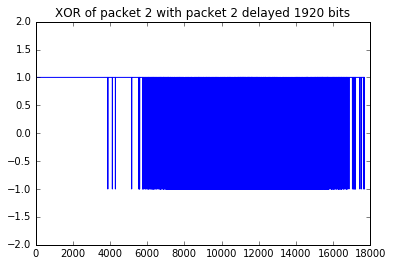

In [16]:
plt.plot(np.sign(bits2[:-1920])*np.sign(bits2[1920:]))
plt.ylim([-2,2])
plt.title('XOR of packet 2 with packet 2 delayed 1920 bits');

Now we investigate sections of data that coincide between both packets. To do so, we look at the peak of the cross-correlation and then do a XOR of packet 1 with packet 2 shifted.

In [17]:
np.argmax(np.correlate(bits2[:1920], bits))

2505

In [18]:
offset = 2505

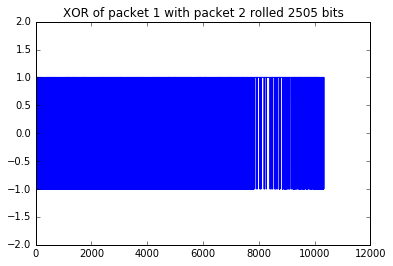

In [19]:
match = np.sign(bits)*np.roll(np.sign(bits2[:bits.size]), -offset)
plt.plot(match)
plt.ylim([-2,2])
plt.title('XOR of packet 1 with packet 2 rolled 2505 bits');

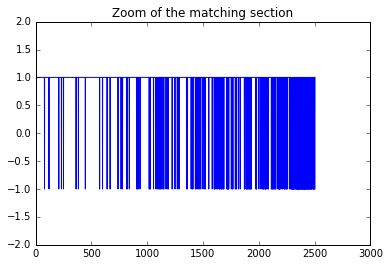

In [20]:
match = np.sign(bits[bits.size-offset:])*np.sign(bits2[:offset])
plt.plot(match)
plt.ylim([-2,2])
plt.title('Zoom of the matching section');